# Notebook configuration

In [1]:
run_number    = 4628
save_plots    = True
plots_format  = "pdf"
outputfolder  = "Michelplots/"
inputfilename = "/Users/Gonzalo/github/NEXTdata/Kr/dst_{}_Michel.h5".format(run_number)
corr_filename = "/Users/Gonzalo/github/NEXTdata/XYmaps/run{}_corrections_5.3mm.h5".format(run_number)
#LT            = 1184.2 #run 4446
LT            = 1549.4 # run 4628

Z_fiducial    =    20,  520
XY_fiducial   =  -178,  178
R_fiducial    =     0,  max(XY_fiducial)
Eevt_limits   =    55,   73
Es2_limits    =    27,   37

Erange_raw    =     0, 15e3
Erange_corr   =   8e3, 14e3

# Imports

In [2]:
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .dst_functions  as dstf
import invisible_cities.reco    .corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import plot_writer

save = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None

Running on  Tue Oct  3 17:56:28 2017


#### General plotting options

In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"         ] = 12, 8
plt.rcParams[  "font.size"            ] = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  =  "-r"

# Read data

In [4]:
full = dstf.load_dst(inputfilename, "DST", "Events")
print("# successfully reconstructed events:", len(set(full.event)))
print("# successfully reconstructed S2s   :", len(    full       ))
full.head(10)

# successfully reconstructed events: 1312583
# successfully reconstructed S2s   : 1404306


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.504810e+09,0,1,150.0,1.628713,7.330867,251400.0,13.3250,1736.060669,...,654500.0,26,403.100,403.100,-5.451280,-23.574825,24.196876,-1.798036,14.205547,15.268265
1,4,1.504810e+09,0,1,125.0,1.674954,7.261290,468600.0,9.6125,1635.041626,...,653500.0,23,184.900,184.900,-195.254694,47.463048,200.940629,2.903135,10.088053,10.934308
2,5,1.504810e+09,0,1,300.0,3.802718,18.196588,345150.0,11.3250,2333.721924,...,653500.0,23,308.350,308.350,-16.273321,40.654008,43.790060,1.951551,11.631449,10.704266
3,6,1.504810e+09,0,1,175.0,2.230152,11.899826,493275.0,8.6000,3127.787598,...,652500.0,27,159.225,159.225,-131.989290,2.424955,132.011564,3.123222,10.273403,17.102090
4,7,1.504810e+09,0,2,325.0,7.637844,41.220879,522725.0,7.3875,2233.775879,...,652500.0,21,129.775,129.775,22.608671,-125.296588,127.320018,-1.392276,25.281292,18.558817
5,7,1.504810e+09,1,2,325.0,7.637844,41.220879,522725.0,11.6875,5178.710449,...,700500.0,73,177.775,177.775,44.268388,-193.239674,198.245458,-1.345597,24.828940,22.703394
6,8,1.504810e+09,0,1,225.0,4.044936,21.512648,389725.0,15.6000,1765.504028,...,653500.0,36,263.775,263.775,20.772980,-121.295034,123.060968,-1.401182,27.055894,14.368792
7,9,1.504810e+09,0,1,125.0,1.464954,6.137459,607100.0,7.7625,3809.636719,...,653500.0,33,46.400,46.400,-65.718077,-137.403871,152.311160,-2.016921,13.745657,29.792755
8,10,1.504810e+09,0,1,175.0,1.815328,10.865719,208075.0,13.5125,1616.475220,...,654500.0,26,446.425,446.425,23.805255,69.800794,73.748498,1.242121,15.698613,18.975458
9,12,1.504810e+09,0,1,350.0,13.030600,74.836507,560950.0,21.6250,8899.816406,...,659500.0,235,98.550,98.550,124.179767,-114.298223,168.774105,-0.743986,52.260854,52.085806


In [14]:
d = np.diff(E) >= 0
print(np.all(d))
np.argwhere(~d)[0]

False


array([26183])

In [17]:
full[26181:26183+5]

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
26181,1716999,214701.116,0,1,375.0,3.227437,19.447060,336075.0,13.3625,1241.049438,...,654500.0,28,318.425,318.425,-183.159642,37.232899,186.905706,2.941044,36.995034,10.513129
26182,1717000,214701.361,0,2,350.0,6.339310,31.491693,599150.0,5.4625,2475.061279,...,651500.0,28,52.350,52.350,190.074684,36.459316,193.539833,0.189514,22.477853,15.024533
26183,1717000,214701.361,1,2,350.0,6.339310,31.491693,599150.0,8.6125,9394.814453,...,685500.0,94,86.350,86.350,151.103343,8.171956,151.324159,0.054029,33.265830,26.971241
26184,17001,2116.611,0,1,150.0,0.995902,5.342389,453025.0,9.3875,2693.868164,...,653500.0,30,200.475,200.475,-87.475467,5.601289,87.654616,3.077647,13.644521,11.805629
26185,17002,2116.820,0,1,400.0,0.891969,9.838920,334450.0,3.5125,2514.956543,...,651500.0,28,317.050,317.050,-80.320088,191.265734,207.446132,1.968373,17.016933,22.055604
26186,17003,2116.907,0,1,250.0,2.810150,16.151526,250800.0,12.4375,1829.464600,...,654500.0,25,403.700,403.700,-7.174535,26.732300,27.678328,1.833002,16.081455,24.515639
26187,17004,2117.010,0,1,350.0,1.350192,11.995820,515900.0,7.3500,2819.551758,...,652500.0,31,136.600,136.600,179.334144,-20.787835,180.534953,-0.115402,38.187715,20.651227


In [12]:
E

array([      1,       4,       5, ..., 1699997, 1699999, 1700000], dtype=int32)

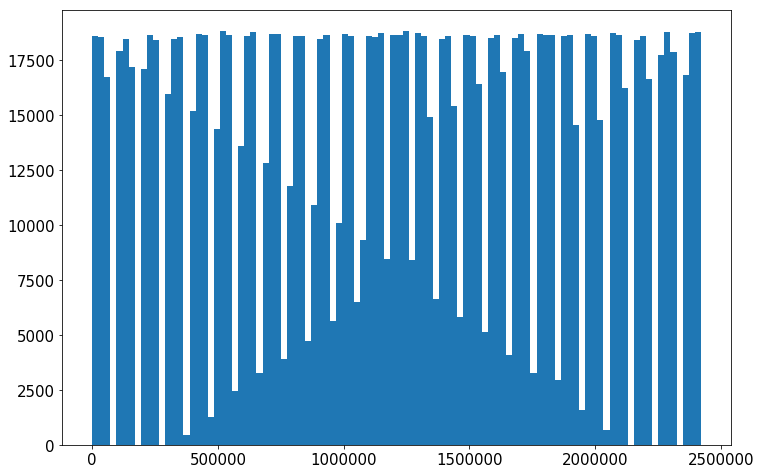

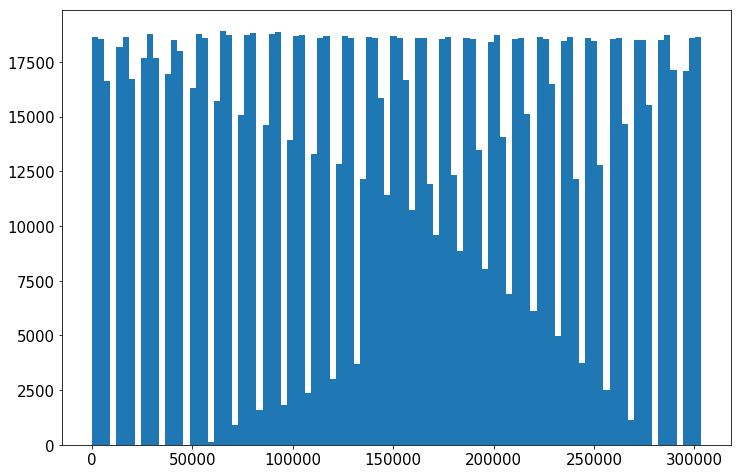

In [18]:
E  = full.event.values
T  = full.time.values
T -= T.min()
hist(E, 100, (E.min(), E.max()));
hist(T, 100, (T.min(), T.max()));

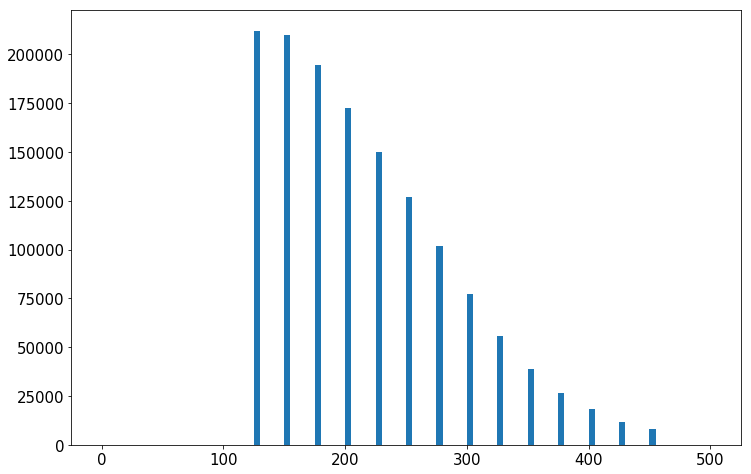

In [19]:
hist(full.S1w.values, 100, (0, 500));

In [5]:
Zcorr  = corrf.LifetimeCorrection(LT, 1)
XYcorr = dstf.load_xy_corrections(corr_filename)

# This line is temporary
XYcorr._fs = XYcorr._fs[37, 37]/XYcorr._fs

# Find energy scale from Kr peak

In [6]:
E_full = full.S2e.values * Zcorr(full.Z.values).value * XYcorr(full.X.values, full.Y.values).value

Energy scale      = 12263.8 pes for 41.5 keV
Conversion factor = 295.5 pes/keV


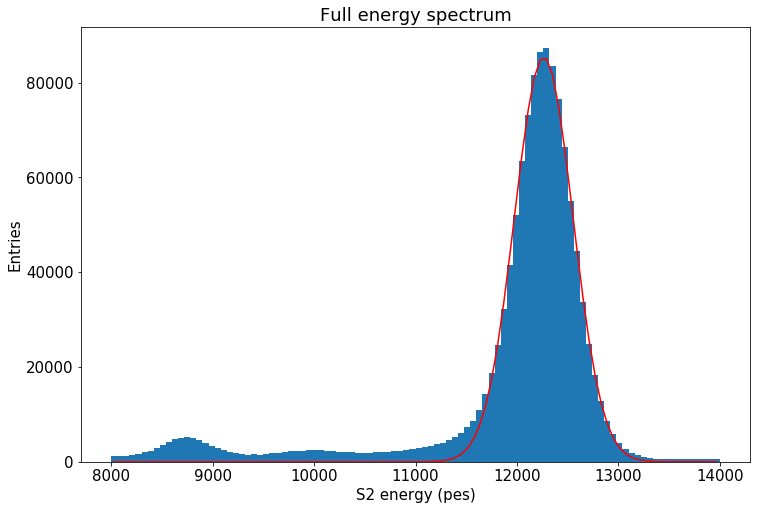

In [7]:
y, x, _ = hist(E_full, 100, Erange_corr)
labels("S2 energy (pes)", "Entries", "Full energy spectrum")

fit_range = x[np.argmax(y) - 10], x[np.argmax(y) + 10]
seed = 1e6, 12e3, 1e3
f = fitf.fit(fitf.gauss, x, y, seed, fit_range=fit_range, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), fitOpt)

E_scale = f.values[1]/41.5
print("Energy scale      = {:.1f} pes for 41.5 keV".format(f.values[1]))
print("Conversion factor = {:.1f} pes/keV".format(E_scale))

# Number of peaks

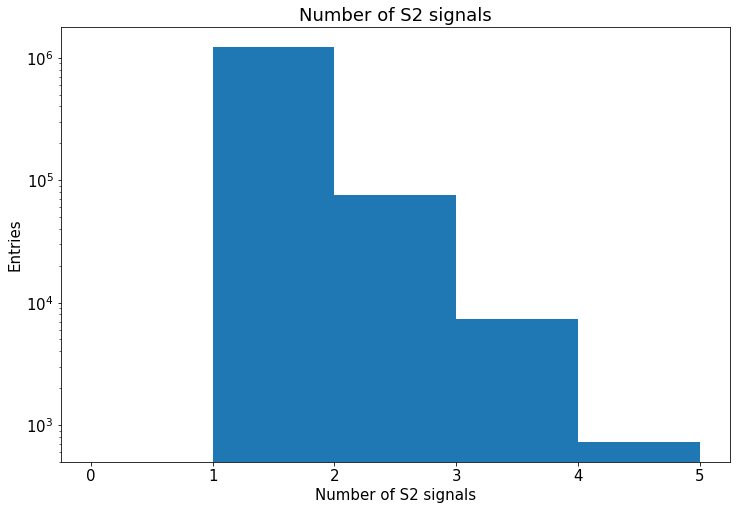

In [8]:
hist(full.nS2, 5, (0, 5), weights = 1/full.nS2)
plt.yscale("log")
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

In [9]:
doubleS2 = full[full.nS2 == 2]
print("Total number of events with 2 S2: {:d}"   .format(    len(doubleS2)//2))
print("Fraction     of events with 2 S2: {:.1f}%".format(100*len(doubleS2)/len(full)))

Total number of events with 2 S2: 74932
Fraction     of events with 2 S2: 10.7%


# Fiducial cuts

In [10]:
z_sel      = coref.in_range(doubleS2.Z.values, *Z_fiducial)
evt_sel    = doubleS2[z_sel].duplicated("event", keep=False)
fiducial_z = doubleS2[z_sel][evt_sel]
print("Total number of events within z limits: {:d}"   .format(    len(fiducial_z)//2))
print("Fraction     of events within z limits: {:.1f}%".format(100*len(fiducial_z)/len(doubleS2)))

Total number of events within z limits: 60837
Fraction     of events within z limits: 81.2%


In [11]:
r_sel      = coref.in_range(fiducial_z.R.values, *R_fiducial)
evt_sel    = fiducial_z[r_sel].duplicated("event", keep=False)
fiducial_r = fiducial_z[r_sel][evt_sel]
print("Total number of events within r limits: {:d}"   .format(    len(fiducial_r)//2))
print("Fraction     of events within r limits: {:.1f}%".format(100*len(fiducial_r)/len(fiducial_z)))

Total number of events within r limits: 38842
Fraction     of events within r limits: 63.8%


In [12]:
fiducial = fiducial_r

In [13]:
evts = fiducial.event.values
X    = fiducial.X    .values
Y    = fiducial.Y    .values
Z    = fiducial.Z    .values
E    = fiducial.S2e  .values / E_scale
Ez   = E  * Zcorr (Z)   .value
Exyz = Ez * XYcorr(X, Y).value

evt_nos = np.array(sorted(set(evts)))
Eevt    = Exyz.reshape((Exyz.size//2, 2)).sum(axis=1)
#np.array([Exyz[evts == evt].sum() for evt in evt_nos])

#  Energy spectra (per S2 and per evt)

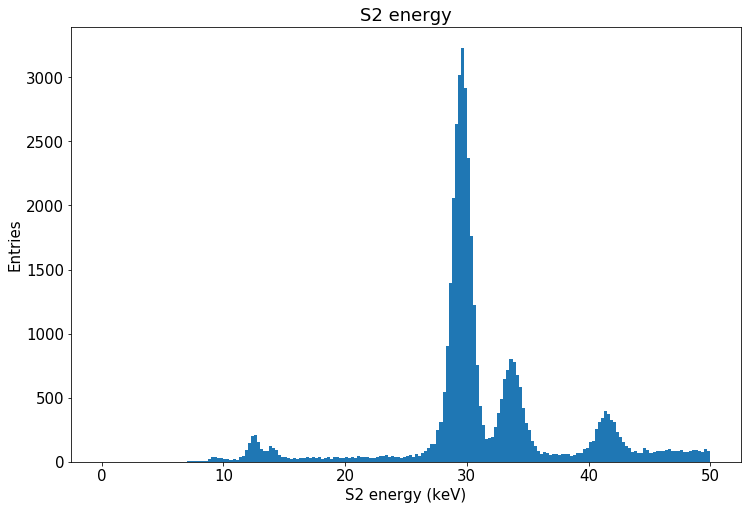

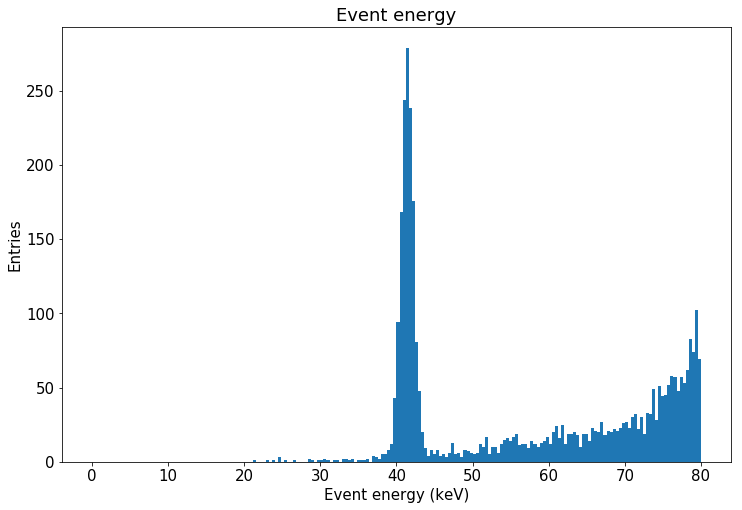

In [14]:
hist(Exyz, 200, (0, 50))
labels("S2 energy (keV)", "Entries", "S2 energy")
save("S2_energy")

y, x, _ = hist(Eevt, 200, (0, 80))
labels("Event energy (keV)", "Entries", "Event energy")
save("Evt_energy")

# Select events within energy windows

In [15]:
Eevt_sel = coref.in_range(Eevt, *Eevt_limits)
print("Total number of events within [{}, {}) keV: {:d}"   .format(*Eevt_limits, np.count_nonzero(Eevt_sel)))
print("Fraction     of events within [{}, {}) keV: {:.1f}%".format(*Eevt_limits, np.count_nonzero(Eevt_sel)*2/len(fiducial)*100))
Eevt_sel  = np.repeat(Eevt_sel, 2)
#evt_nos_pass_sum = evt_nos[sel]
#evts_pass_sum    = np.in1d(evts, evt_nos_pass_sum)
#E_pass_sum       = E[evts_pass_sum]


Total number of events within [55, 73) keV: 853
Fraction     of events within [55, 73) keV: 2.2%


Total number of events with both S2s within [27, 37) keV: 323
Fraction     of events with both S2s within [27, 37) keV: 37.9%


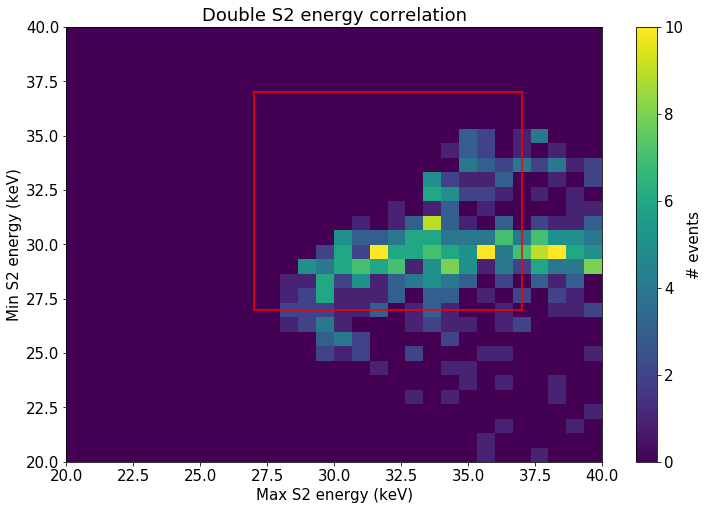

In [16]:
e = Exyz[Eevt_sel]
e = e.reshape((e.size//2, 2))
e.sort(axis=1)
hist2d(e[:, 1], e[:, 0], 30, ((20, 40), (20, 40)))
plt.colorbar().set_label("# events")
labels("Max S2 energy (keV)", "Min S2 energy (keV)", "Double S2 energy correlation")

min_, max_ = Es2_limits
plt.plot([min_, max_], [min_, min_], "r")
plt.plot([min_, max_], [max_, max_], "r")
plt.plot([min_, min_], [min_, max_], "r")
plt.plot([max_, max_], [min_, max_], "r")

Es2_sel = (coref.in_range(e[:, 0], min_, max_) &
           coref.in_range(e[:, 1], min_, max_))

#print("Total number of events with both S2s within [{}, {}) keV: {}".format(*Es2_limits, np.count_nonzero(Es2_sel)))

print("Total number of events with both S2s within [{}, {}) keV: {:d}"   .format(*Es2_limits, np.count_nonzero(Es2_sel)))
print("Fraction     of events with both S2s within [{}, {}) keV: {:.1f}%".format(*Es2_limits, np.count_nonzero(Es2_sel)*2/e.size*100))

Es2_sel = np.repeat(Es2_sel, 2)

# Energy spectrum for selected events

In [17]:
selected   = fiducial[Eevt_sel][Es2_sel]
X_selected = X       [Eevt_sel][Es2_sel]
Y_selected = Y       [Eevt_sel][Es2_sel]
Z_selected = Z       [Eevt_sel][Es2_sel]
E_selected = Exyz    [Eevt_sel][Es2_sel]

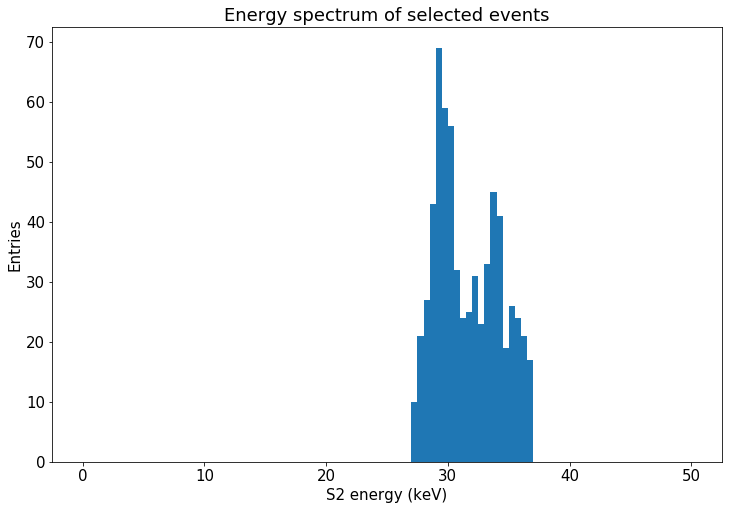

In [18]:
hist(E_selected, 100, (0, 50))
labels("S2 energy (keV)", "Entries", "Energy spectrum of selected events")

# 3D distance between clusters

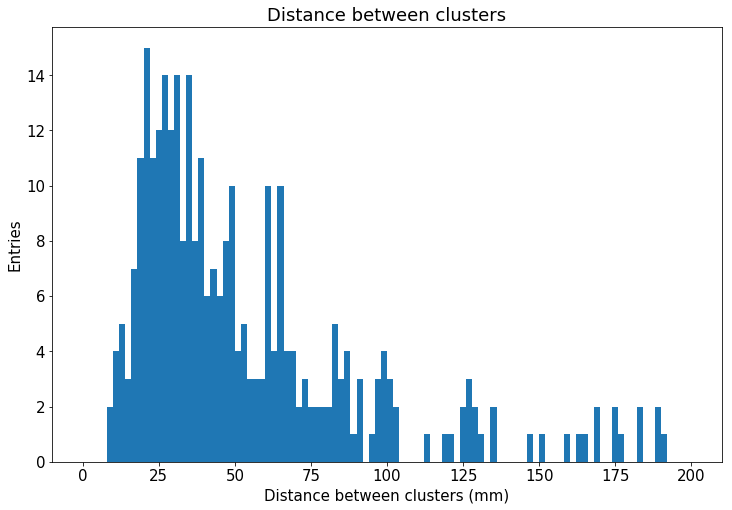

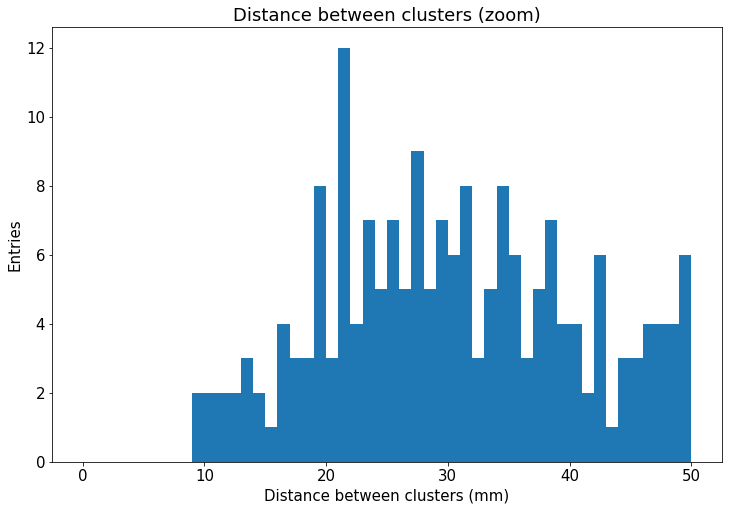

In [19]:
dx  = np.sum(np.diff(X_selected.reshape((X_selected.size//2, 2)), axis = 1), axis=1)
dy  = np.sum(np.diff(Y_selected.reshape((X_selected.size//2, 2)), axis = 1), axis=1)
dz  = np.sum(np.diff(Z_selected.reshape((X_selected.size//2, 2)), axis = 1), axis=1)

dr = (dx**2 + dy**2 + dz**2)**0.5

y, x, _ = hist(dr, 100, (0, 200))
labels("Distance between clusters (mm)", "Entries", "Distance between clusters")

hist(dr, 50, (0, 50))
labels("Distance between clusters (mm)", "Entries", "Distance between clusters (zoom)")